In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import xgboost as xgb

C:\Users\shane\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [3]:
df = pd.read_csv('../data/heart_2020.csv')
df.head()

,HeartDisease,BMI,Smoking,AlcoholDrinking,Stroke,PhysicalHealth,MentalHealth,DiffWalking,Sex,AgeCategory,Race,Diabetic,PhysicalActivity,GenHealth,SleepTime,Asthma,KidneyDisease,SkinCancer
0,No,16.60,Yes,No,No,3.0,30.0,No,Female,55-59,White,Yes,Yes,Very good,5.0,Yes,No,Yes
1,No,20.34,No,No,Yes,0.0,0.0,No,Female,80 or older,White,No,Yes,Very good,7.0,No,No,No
2,No,26.58,Yes,No,No,20.0,30.0,No,Male,65-69,White,Yes,Yes,Fair,8.0,Yes,No,No
3,No,24.21,No,No,No,0.0,0.0,No,Female,75-79,White,No,No,Good,6.0,No,No,Yes
4,No,23.71,No,No,No,28.0,0.0,Yes,Female,40-44,White,No,Yes,Very good,8.0,No,No,No


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 319795 entries, 0 to 319794
Data columns (total 18 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   HeartDisease      319795 non-null  object 
 1   BMI               319795 non-null  float64
 2   Smoking           319795 non-null  object 
 3   AlcoholDrinking   319795 non-null  object 
 4   Stroke            319795 non-null  object 
 5   PhysicalHealth    319795 non-null  float64
 6   MentalHealth      319795 non-null  float64
 7   DiffWalking       319795 non-null  object 
 8   Sex               319795 non-null  object 
 9   AgeCategory       319795 non-null  object 
 10  Race              319795 non-null  object 
 11  Diabetic          319795 non-null  object 
 12  PhysicalActivity  319795 non-null  object 
 13  GenHealth         319795 non-null  object 
 14  SleepTime         319795 non-null  float64
 15  Asthma            319795 non-null  object 
 16  KidneyDisease     31

In [5]:
df.isna().sum()

HeartDisease        0
BMI                 0
Smoking             0
AlcoholDrinking     0
Stroke              0
PhysicalHealth      0
MentalHealth        0
DiffWalking         0
Sex                 0
AgeCategory         0
Race                0
Diabetic            0
PhysicalActivity    0
GenHealth           0
SleepTime           0
Asthma              0
KidneyDisease       0
SkinCancer          0
dtype: int64

In [44]:
df['HeartDisease'].value_counts()

No     292422
Yes     27373
Name: HeartDisease, dtype: int64

In [6]:
df.describe()

,BMI,PhysicalHealth,MentalHealth,SleepTime
count,319795.000000,319795.00000,319795.000000,319795.000000
mean,28.325399,3.37171,3.898366,7.097075
std,6.356100,7.95085,7.955235,1.436007
min,12.020000,0.00000,0.000000,1.000000
25%,24.030000,0.00000,0.000000,6.000000
50%,27.340000,0.00000,0.000000,7.000000
75%,31.420000,2.00000,3.000000,8.000000
max,94.850000,30.00000,30.000000,24.000000


In [7]:
cat_cols = df.select_dtypes(include='object').columns
cat_cols

Index(['HeartDisease', 'Smoking', 'AlcoholDrinking', 'Stroke', 'DiffWalking',
       'Sex', 'AgeCategory', 'Race', 'Diabetic', 'PhysicalActivity',
       'GenHealth', 'Asthma', 'KidneyDisease', 'SkinCancer'],
      dtype='object')

In [8]:
df2 = pd.get_dummies(df,cat_cols,drop_first=True)

In [9]:
X = df2.loc[:,df2.columns!='HeartDisease_Yes']
y = df2['HeartDisease_Yes']

In [10]:
from sklearn.model_selection import train_test_split


In [84]:
X_train, X_test , y_train, y_test = train_test_split(X,y,test_size=.30, random_state= 42)

In [85]:
from imblearn.over_sampling import RandomOverSampler

In [86]:
rs = RandomOverSampler(sampling_strategy=.4, random_state=42)

In [87]:
X_train_rs, y_train_rs = rs.fit_resample(X_train,y_train)

In [88]:
y_train_rs.value_counts()

0    204773
1     81909
Name: HeartDisease_Yes, dtype: int64

In [89]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import  GradientBoostingClassifier
from sklearn.metrics import roc_curve,roc_auc_score


In [90]:
algos = {
    'Decision_Tree': {
        'model': DecisionTreeClassifier(),
        'params': {
            'criterion' : ['gini','entropy',],
            'splitter': ['best'],
            'max_features': ['sqrt','log2'],
            'random_state': [42]
        }
    },
    'Random_Forest' : {
        'model' : RandomForestClassifier(),
        'params' : {
            'criterion' : ['gini','entropy',],
            'n_estimators': [150,250],
            'max_features': ['sqrt','log2'],
            'random_state': [42],
        }
    },
    'Logistic_Regression' :{
        'model' : LogisticRegression(),
        'params' : {
            'max_iter': [100,200],
            'random_state': [42],

        }
    },
    'Gradient_Boosting' :{
        'model' : GradientBoostingClassifier(),
        'params' : {
            'learning_rate': [.1,.2,.25],
            'n_estimators': [150,250],
            'criterion' : ['friedman_mse','squared_error',],
            'max_features': ['sqrt','log2'],
            'random_state': [42],
        }
    }

}

In [91]:
scores = []
models ={}
for algo_name, config in algos.items():
    gs =  GridSearchCV(config['model'], config['params'], cv=3, return_train_score=False, n_jobs=-1, scoring='roc_auc')
    gs.fit(X_train_rs,y_train_rs)
    scores.append({
        'model': algo_name,
        'best_score': gs.best_score_,
        'best_params': gs.best_params_
    })
    models[algo_name] = gs
pd.DataFrame(scores,columns=['model','best_score','best_params'])



C:\Users\shane\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


,model,best_score,best_params
0,Decision_Tree,0.945672,"{'criterion': 'gini', 'max_features': 'log2', ..."
1,Random_Forest,0.990393,"{'criterion': 'gini', 'max_features': 'sqrt', ..."
2,Logistic_Regression,0.840547,"{'max_iter': 200, 'random_state': 42}"
3,Gradient_Boosting,0.847272,"{'criterion': 'friedman_mse', 'learning_rate':..."


In [92]:
plt.rcParams.update({'font.size': 12})
plt.rc('xtick', labelsize=12)
plt.rc('ytick', labelsize=12)

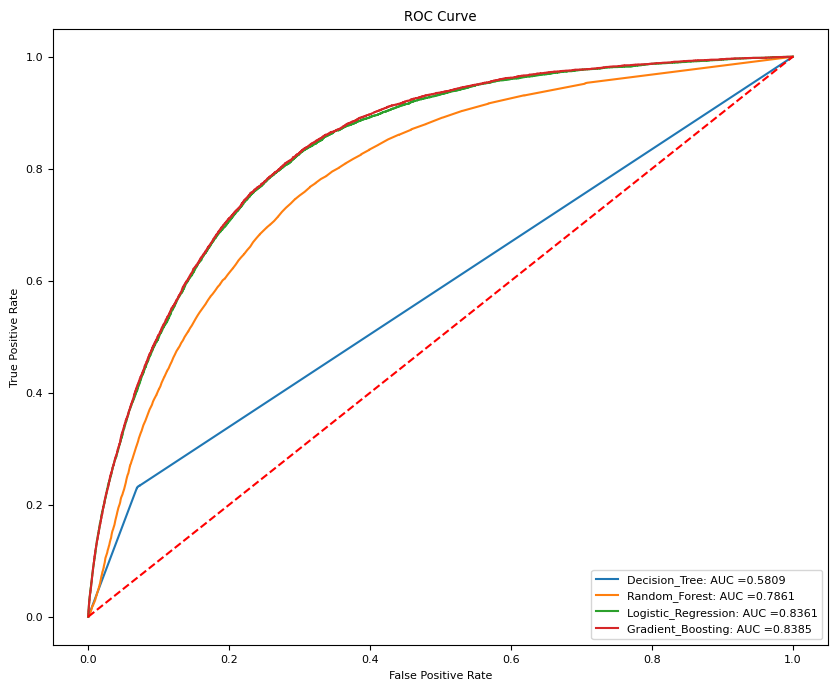

In [106]:
fig, ax = plt.subplots(figsize = (10,8))
for algo_name ,model in models.items():
    y_pred_proab = model.predict_proba(X_test)[::,1]
    fpr, tpr, _ = roc_curve(y_test,y_pred_proab)
    auc = roc_auc_score(y_test,y_pred_proab)
    ax.plot(fpr,tpr, label = f'{algo_name}: AUC ={round(auc,4)}')
ax.plot([0,1],[0,1], c='red', linestyle='dashed')
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.legend(loc=4)
plt.title('ROC Curve')
plt.savefig('../images/Roc_curve',bbox_inches='tight')
plt.show()

In [94]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report

In [95]:
for algo_name ,model in models.items():
    y_pred = model.predict(X_test)
    print(algo_name)
    print('--------------------------------------------------------')
    print(classification_report(y_test,y_pred))


Decision_Tree
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.93      0.93     87649
           1       0.23      0.23      0.23      8290

    accuracy                           0.87     95939
   macro avg       0.58      0.58      0.58     95939
weighted avg       0.87      0.87      0.87     95939

Random_Forest
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.95      0.94     87649
           1       0.30      0.21      0.25      8290

    accuracy                           0.89     95939
   macro avg       0.61      0.58      0.59     95939
weighted avg       0.87      0.89      0.88     95939

Logistic_Regression
--------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.90      0.92     87649
           1      

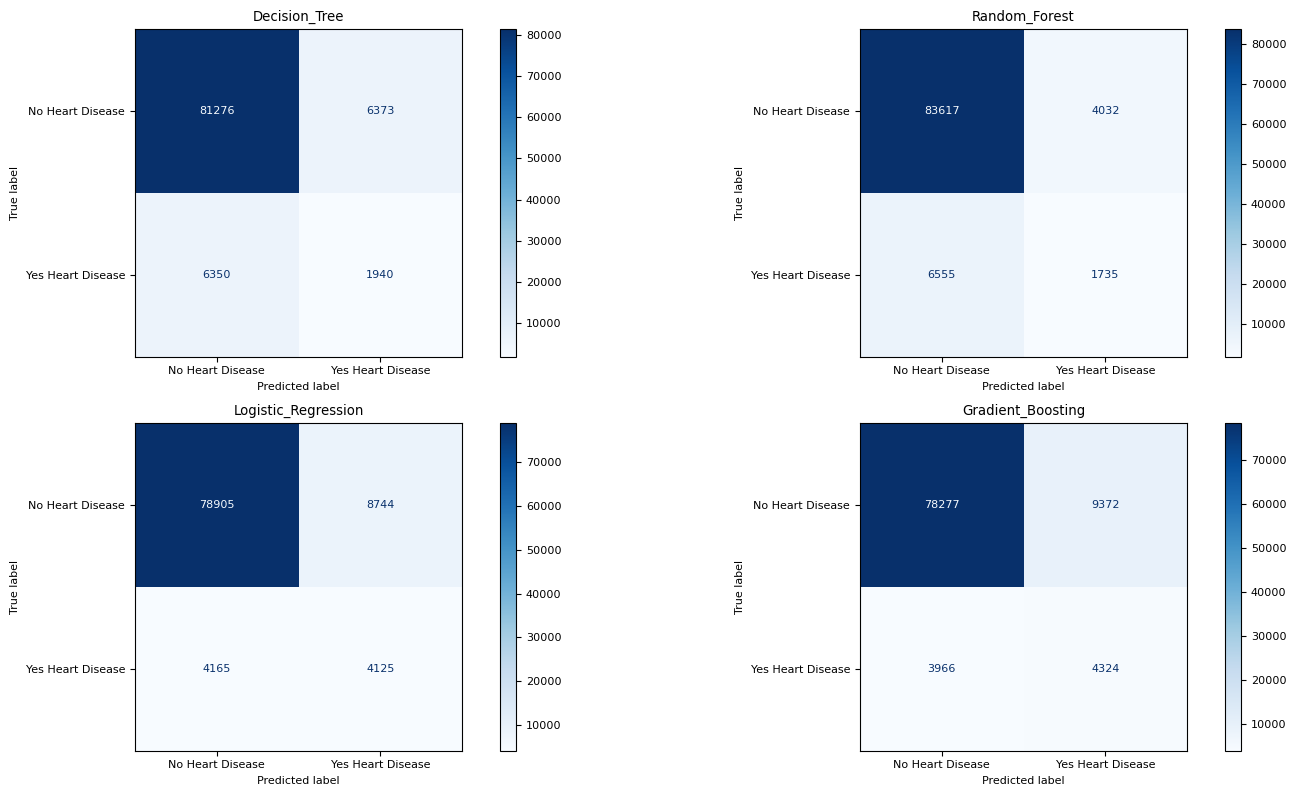

In [105]:
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15,8))
plt.rcParams.update({'font.size': 8})
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)

for cls, ax , algo_name in zip(models.values(), axes.flatten(),models.keys()):
    ConfusionMatrixDisplay.from_estimator(cls,X_test,y_test,ax=ax, cmap='Blues', display_labels=['No Heart Disease','Yes Heart Disease'])
    ax.title.set_text(algo_name)
plt.tight_layout()
# plt.savefig('../images/confusion_matrix_heart.png',bbox_inches='tight')
plt.show()

In [97]:
ty